# Quora Question Pair (TF-IDF)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
warnings.filterwarnings("ignore")
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os

import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [4]:
nlp_features_train=pd.read_csv('nlp_features_train.csv',encoding='latin-1')
nlp_features_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [5]:
df_fe_without_preprocessing_train=pd.read_csv('df_fe_without_preprocessing_train.csv',encoding='latin-1')
df_fe_without_preprocessing_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [14]:
df1=nlp_features_train.drop(['qid1','qid2'],axis=1)
df2=df_fe_without_preprocessing_train.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
data=df1.merge(df2,on='id',how='left')

In [15]:
data.head()

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [16]:
y_true = data['is_duplicate']
data.drop(['id','is_duplicate'], axis=1, inplace=True)

# Random train test split( 70:30)

In [17]:
#spliting the data into train and test dataset (70:30) 
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_class, test_size=0.3)

In [18]:
print(X_train.shape)
print(X_test.shape)

(283003, 28)
(121287, 28)


# TF-IDF Vectorizer

In [19]:
#transforming question1 and question2 of train dataset
tfidf = TfidfVectorizer()
train_q1 = tfidf.fit_transform(X_train['question1'].values.astype('U'))
test_q1 =tfidf.transform(X_test['question1'].values.astype('U'))
train_q2 = tfidf.fit_transform(X_train['question2'].values.astype('U'))
test_q2 =tfidf.transform(X_test['question2'].values.astype('U'))

In [20]:
#Dropping question-1 and question-2 and Replacing with tfidf values
X_train.drop(['question1','question2'], axis=1, inplace=True)
X_test.drop(['question1','question2'], axis=1, inplace=True)

In [21]:
#Combining Question-1 and Question-2 using hstack function
train_tfidf = hstack((train_q1,train_q2))
test_tfidf = hstack((test_q1,test_q2))

In [22]:
#combining all basic,advanced and tfidf features
X_train = hstack((X_train, train_tfidf)).tocsr()
X_test = hstack((X_test, test_tfidf)).tocsr()

In [23]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 111659)
Number of data points in test data : (121287, 111659)


In [24]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [25]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Machine Learning Models

<h2> Building a random model (Finding worst-case log-loss) </h1>

Log loss on Test Data using Random Model 0.8915917005269305


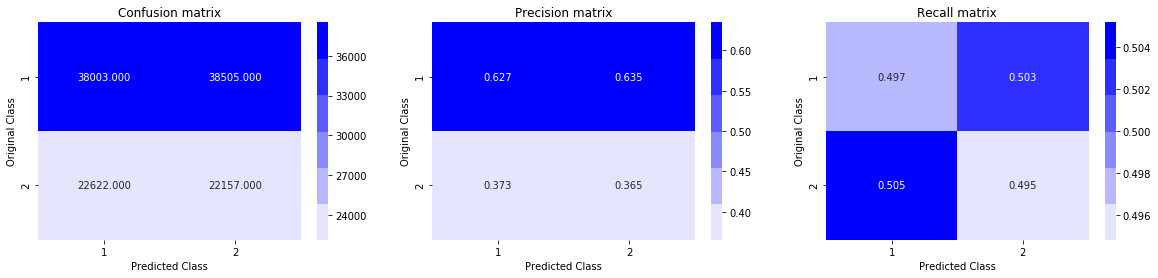

In [27]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> Logistic Regression with hyperparameter tuning </h1>

For values of alpha =  1e-05 The log loss is: 0.4404812019798702
For values of alpha =  0.0001 The log loss is: 0.4419241980190591
For values of alpha =  0.001 The log loss is: 0.44183723338715497
For values of alpha =  0.01 The log loss is: 0.4440127867611482
For values of alpha =  0.1 The log loss is: 0.4605534962384613
For values of alpha =  1 The log loss is: 0.4910757774924735
For values of alpha =  10 The log loss is: 0.5464668533369135


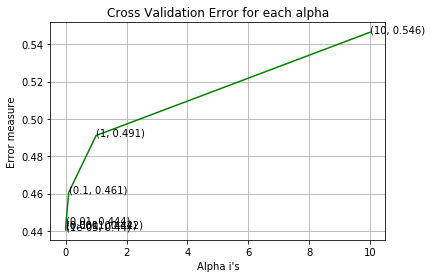

For values of best alpha =  1e-05 The train log loss is: 0.4412818290858845
For values of best alpha =  1e-05 The test log loss is: 0.4404812019798702
Total number of data points : 121287


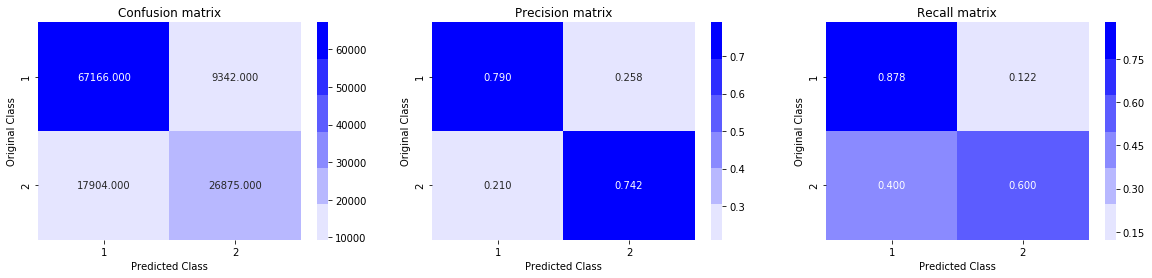

In [28]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.44403796234308573
For values of alpha =  0.0001 The log loss is: 0.48014360792584965
For values of alpha =  0.001 The log loss is: 0.5074698197990206
For values of alpha =  0.01 The log loss is: 0.5135818740402268
For values of alpha =  0.1 The log loss is: 0.5077685029951705
For values of alpha =  1 The log loss is: 0.5848491377580852
For values of alpha =  10 The log loss is: 0.6026526308253434


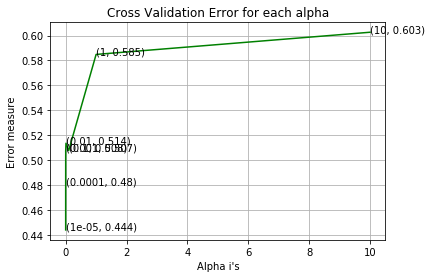

For values of best alpha =  1e-05 The train log loss is: 0.4445975276151823
For values of best alpha =  1e-05 The test log loss is: 0.44403796234308573
Total number of data points : 121287


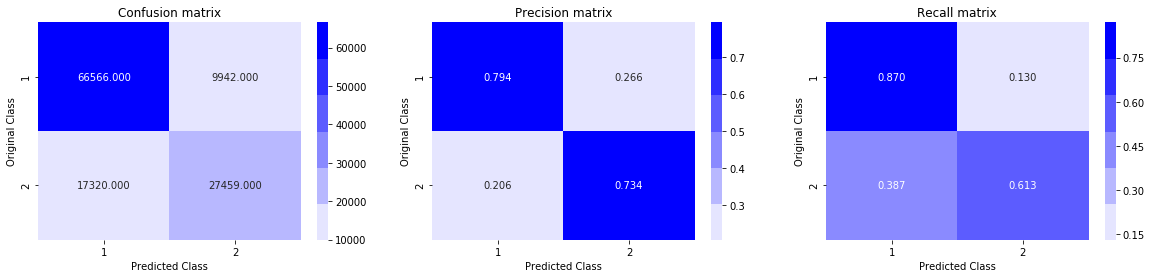

In [29]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [31]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","vectorizer","Best Hyperperameter","Train log loss","Test log loss"]
x.add_row(['Logistic regression','TF-IDF','alpha = 0.00001' ,'0.4412','0.4404'])
x.add_row(['Linear SVM','TF-IDF','alpha = 0.00001','0.4445','0.4440'])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+---------------------+------------+---------------------+----------------+---------------+
|        Model        | vectorizer | Best Hyperperameter | Train log loss | Test log loss |
+---------------------+------------+---------------------+----------------+---------------+
| Logistic regression |   TF-IDF   |   alpha = 0.00001   |     0.4412     |     0.4404    |
|      Linear SVM     |   TF-IDF   |   alpha = 0.00001   |     0.4445     |     0.4440    |
+---------------------+------------+---------------------+----------------+---------------+
